In [17]:
%load_ext autoreload
%autoreload 1
%aimport ECGDataset
%aimport Models
%aimport Net
%aimport train_test_validat
%aimport ecg_plot
%aimport logger
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd

import time
import math
import os
import gc
import random


import sys
import logger


from torch.utils.tensorboard import SummaryWriter


time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 
model_path = './model/'+time_str
log_path = './logs/'+  time_str

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 160

FOLDS = 5
EPOCHS = 100  
PATIENCE = 10
LR = 0.01
    
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl//',filter_age= 18,filter_department='外科',rebuild_flage=False)
ALLDataset.report()  # type: ignore
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0
105375
              HTN        NHTN   
   nums       1871      103504  


            orginal            QC         
   nums      105375          105375       
              HTN        NHTN   
   nums       1871      103504  


            orginal   filtered department 
   nums      105375          21961        
              HTN        NHTN   
   nums       1871      20090   


            orginal     removed ages NaN  
   nums      21961           21961        
              HTN        NHTN   
   nums       1871      20090   


            orginal      filtered ages    
   nums      21961           20986        
              HTN        NHTN   
   nums       1834      19152   


            orginal   removed diagnose NaN
   nums      20986           20981        
              HTN        NHTN   
   nums       1834      19147   


ERR labels num: 58


            orginal    removed duplicat

In [ ]:
y = np.array([0,0,0,0,1,0,0,0,0,1])
y_ = np.array([0,0,0,1,1,0,0,0,0,0])

In [2]:
import augmenters

In [3]:
x = torch.zeros((2,12,5000))
y = torch.zeros((2,1))

In [10]:
augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))


tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-1.0111e-03, -1.1979e-03, -5.4929e-04,  ..., -1.7903e-04,
           3.8441e-04, -9.3332e-04],
         [ 6.7130e-03,  6.6709e-03,  6.6287e-03,  ..., -3.9060e-02,
          -3.9039e-02, -3.9017e-02],
         [ 4.4092e-02,  4.3898e-02,  4.3702e-02,  ..., -2.8833e-01,
          -2.8813e-01, -2.8794e-01],
         ...,
         [ 4.7884e-02,  4

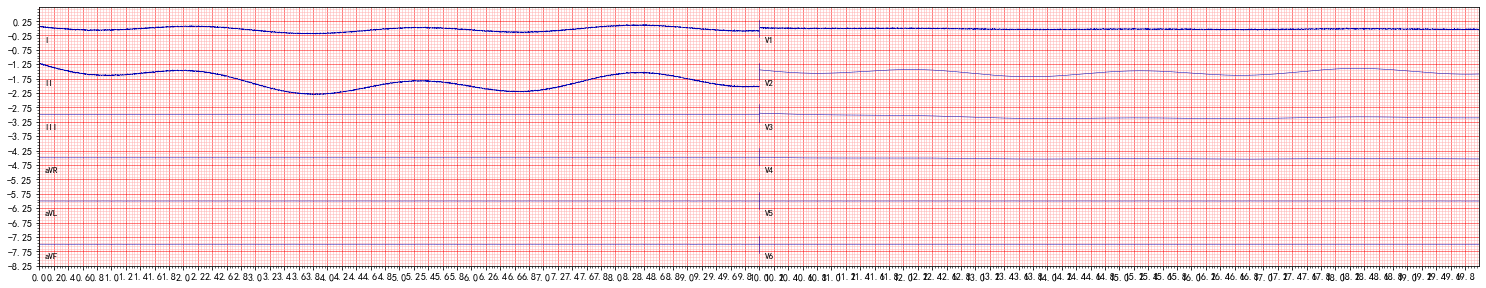

In [16]:
ecg_plot.plot(augmenters.gen_baseline_wander(x,500,prob=torch.rand(1))[0],500,'',columns=2,row_height= 3,show_grid=True,show_separate_line=True)  # type: ignore

In [19]:
testdf = ALLDataset.INFOsDf.copy()

In [3]:
df1 = testdf[testdf['ID']=='']
df1 = df1.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df1[df1.duplicated(subset=['name','ages','gender'])]

,num,name,ages,gender,diagnose,department,ID,date,ecgFN,q_sum
21045,508,李添福,56,男,1,,,,00-508_56-1_HTN.npy,0
21057,509,李添福,56,男,1,,,,00-509_56-1_HTN.npy,0
21400,537,陈庆荣,78,男,1,,,,00-537_78-1_HTN.npy,0
21497,545,陈瑞慧,36,女,1,,,,00-545_36-0_HTN.npy,0
19957,419,林志海,42,男,1,,,,00-419_42-1_HTN.npy,1
...,...,...,...,...,...,...,...,...,...,...
18506,300,万秋菊,72,女,1,,,,00-300_72-0_HTN.npy,10
18530,302,万秋菊,72,女,1,,,,00-302_72-0_HTN.npy,0
18554,304,万秋菊,72,女,1,,,,00-304_72-0_HTN.npy,1
18601,308,范志洪,36,男,1,,,,00-308_36-1_HTN.npy,0


In [24]:
df2 = testdf[~(testdf['ID']=='')]
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index
df2.loc[duplicated_index,'diagnose'] = 1


In [13]:
df2 = df2.sort_values(by=['diagnose'], ascending=[False]) #按照诊断排序，HTN在前
df2_0 = df2[df2['diagnose']==0] #所有非高血压
df2_1 = df2[df2['diagnose']==1] #所有高血压

duplicated_index = df2_0[[True if i in df2_1['ID'].tolist() else False for i in df2_0['ID']]].index

<AxesSubplot:>

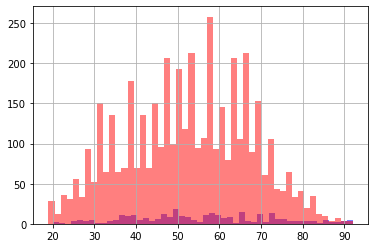

In [2]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

<AxesSubplot:>

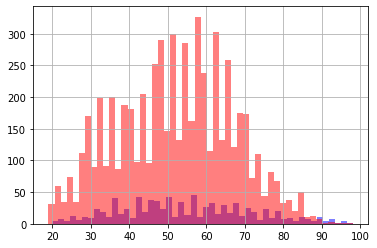

In [3]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].hist(color='b', alpha=0.5, bins=50)
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].hist(color='r', alpha=0.5, bins=50)

<AxesSubplot:ylabel='Density'>

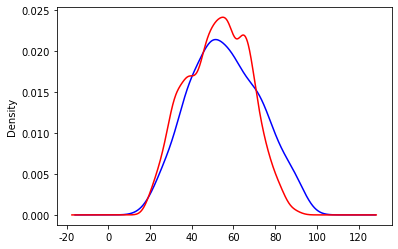

In [4]:
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.testDf[(ALLDataset.testDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

<AxesSubplot:ylabel='Density'>

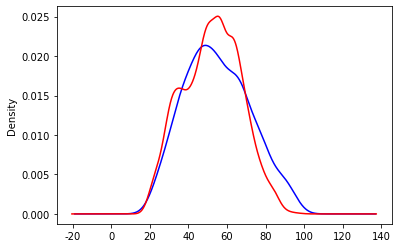

In [5]:
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)]['ages'].plot(kind='kde',color='b')
ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==0)]['ages'].plot(kind='kde',color='r')

In [6]:
def pair_HTN(INPUT_HTN_Df,INPUT_NHTN_Df,Range_max = 10,shuffle = False):
    HTN_Df = ((INPUT_HTN_Df).copy())
    NHTN_Df = ((INPUT_NHTN_Df).copy())#即抽即删,抽出一条删一条
    if(shuffle): #打乱
        HTN_Df = (HTN_Df.sample(frac=1))
        NHTN_Df = (NHTN_Df.sample(frac=1))
    # pair_Df = INFOs_df = pd.DataFrame(index=range(len(HTN_Df)*2),columns=HTN_Df.columns)   #所有的HNT和抽取出来的NHTN都存放入其中
    pair_Df = HTN_Df #先将所有HTN存放入其中
    index = len(HTN_Df)
    for info in HTN_Df.itertuples():
        age = info.ages
        gender = info.gender
        candidate_NHTN_Df = pd.DataFrame()
        
        for Range in range(1,Range_max): # 在 ±Range_max 范围内搜寻ages，且gender相同的NHTN样本
            candidate_NHTN_Df = NHTN_Df[(NHTN_Df['ages']>age-Range)&(NHTN_Df['ages']<age+Range)&(NHTN_Df['gender']==gender)]
            if(len(candidate_NHTN_Df) > 0):
                break
        
        if(len(candidate_NHTN_Df)<1):# ±Range_max 范围内都没有，那么就从所有NHTN样本（删除掉之前被抽到的）中抽一个
            print("lack sample like :",info)
            candidate_NHTN_Df = NHTN_Df
        NHTN_data_buff = candidate_NHTN_Df.sample(n=1) #从candida中随机抽样一个
        # pair_Df.iloc[index] = NHTN_data_buff.iloc[0]
        pair_Df = pair_Df.append(NHTN_data_buff)
        # print(age,',',NHTN_data_buff['ages'])
        # print(NHTN_data_buff.index)
        NHTN_Df = NHTN_Df.drop(index= (NHTN_data_buff.index))
        index = index +1
    return pair_Df
        
            

In [7]:
testsize = len(ALLDataset.tvDf[(ALLDataset.tvDf['diagnose']==1)])//5
# print(testsize)
for i in range(5):
    All_df = ALLDataset.tvDf.copy()    
    validate_pair_Df = pair_HTN(All_df[(All_df['diagnose']==1)].iloc[testsize*i:testsize*i+testsize],All_df[(All_df['diagnose']==0)],Range_max = 15)
    validate_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',validate_pair_Df)
    All_df = All_df.drop(index= validate_pair_Df.index)    #删掉validate_pair_Df
    train_pair_Df_ = pair_HTN(All_df[(All_df['diagnose']==1)],All_df[(All_df['diagnose']==0)],Range_max = 15)
    
    

100%|██████████| 340/340 [00:12<00:00, 26.56it/s]


In [9]:
Model = Net.MLBFNet(2)

In [10]:
x,y = validate_dataset.__getitem__(0)
Model(x)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
from scipy.signal import butter, lfilter

In [ ]:
filter_lowcut = 1.0
filter_highcut = 47.0
filter_order = 1

In [ ]:

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

In [ ]:
X,Y = test_dataset.__getitem__(0)
ecg_plot.plot(X/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore

In [ ]:
X_filtet = bandpass_filter(X, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=500, filter_order=filter_order)# type: ignore  

In [ ]:
ecg_plot.plot(X_filtet/100,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore